**Copyright © 2025 Raphael Senn. Licensed under the MIT License.**

**Author:** Raphael Senn (<raphaelsenn@gmx.de>)

# Conditional Generative Adversarial Networks (Mirza and Osindero, 2014)

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
from torchvision.datasets import MNIST

from src.cgan_fc import (
    Generator,
    Discriminator,
)

from src.objective import (
    GeneratorLoss,
    DiscriminatorLoss
)

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

#### Exploring the training dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                      # pixel transform: img.range[0, 255] -> img.range[0, 1]
    transforms.Lambda(lambda x: x.view(-1))     # shape transfrom: img.shape[1, 28, 28] -> img.shape[1, 784]
])

dataset = MNIST(root='./MNIST/', train=True, download=True, transform=transform)

#### Visualizing the Training Data

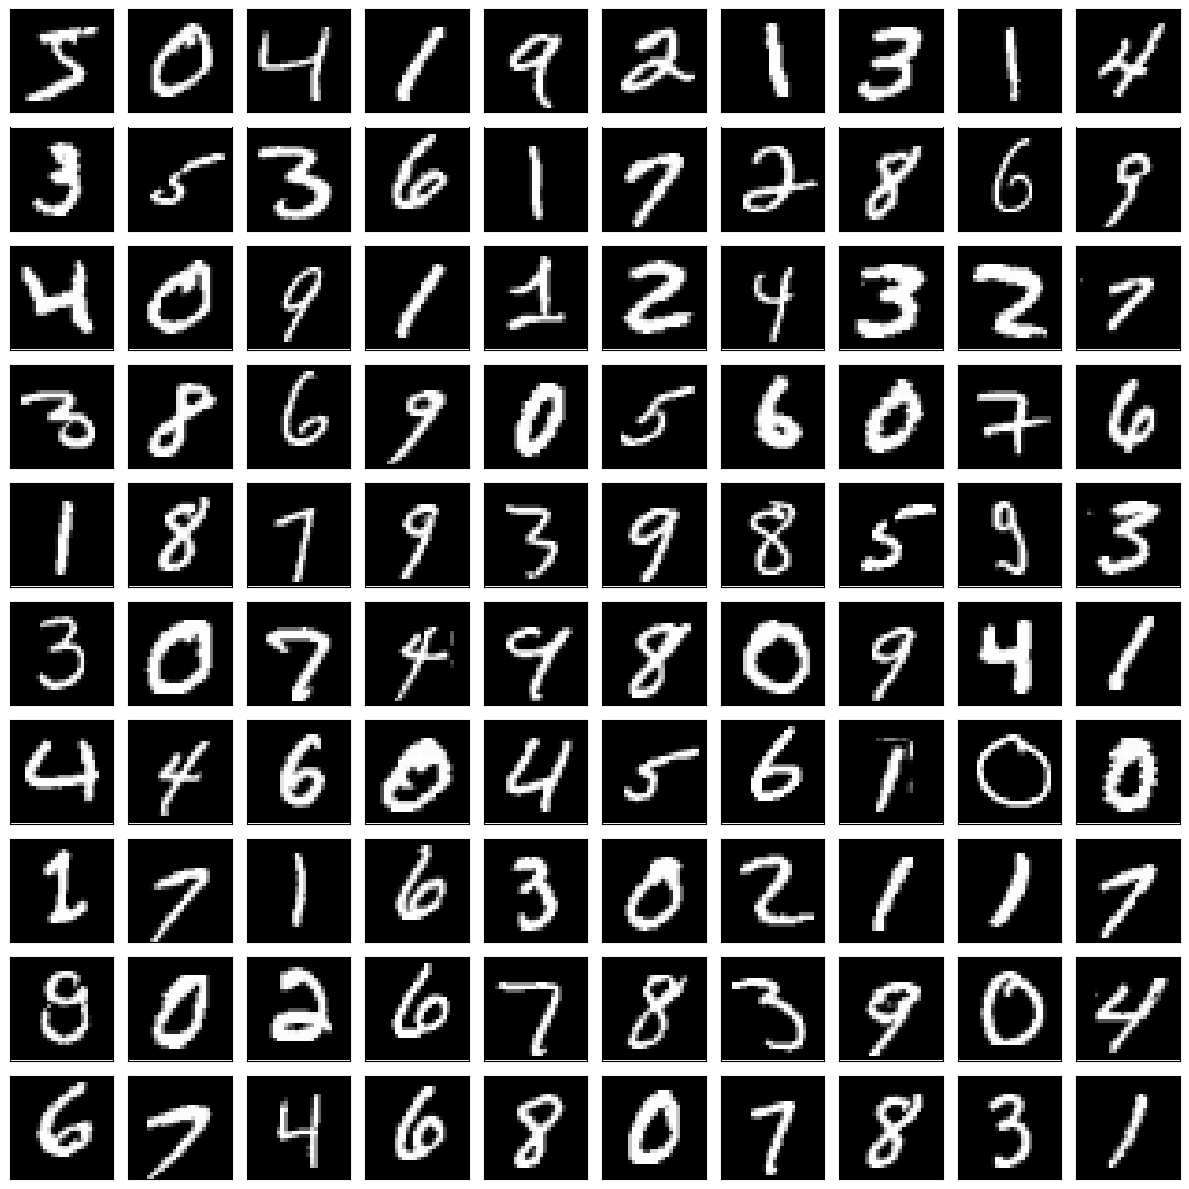

In [4]:
FIGSIZE = (12, 12)
IMAGE_SHAPE = (28, 28)
N_ROWS, N_COLS = 10, 10

_, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
ax = ax.flatten()

for i in range(N_ROWS * N_COLS):
    img, _ = dataset[i]
    img = img.reshape(IMAGE_SHAPE)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_xticks([]),
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

#### Training Setup

In [5]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(SEED)
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): 
    device = torch.device('mps')
else: 
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: mps


In [ ]:
# Create conditional generator and discriminator
DIM_NOISE = 100
generator = Generator(DIM_NOISE).to(device)
discriminator = Discriminator().to(device)

# Hyperparameters
EPOCHS = 100
BATCH_SIZE = 128
SHUFFLE = True

LR_G = 0.002
LR_D = 0.002

BETAS_G = (0.5, 0.999)
BETAS_D = (0.5, 0.999)

# Create the optimizer and the loss
criterion_g = GeneratorLoss()
optimizer_g = torch.optim.Adam(params=generator.parameters(), lr=LR_G, betas=BETAS_G)

criterion_d = DiscriminatorLoss()
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=LR_D, betas=BETAS_D)

# Load the dataset
dataloader = DataLoader(dataset, BATCH_SIZE, SHUFFLE)

In [7]:
num_params_g = sum(p.numel() for p in generator.parameters())
num_params_d = sum(p.numel() for p in discriminator.parameters())
print(f'Generator has: {num_params_g} learnable parameters')
print(f'Discrimintor has: {num_params_d} learnable parameters')

Generator has: 2413984 learnable parameters
Discrimintor has: 1224351 learnable parameters


In [8]:
# Print settings
VERBOSE = True

# Plot settings
Z = torch.rand(size=(N_ROWS * N_COLS, DIM_NOISE), device=device) * 2 - 1
Y = torch.tensor([i for i in range(0, 10) for _ in range(0, 10)], device=device)
Y = F.one_hot(Y, num_classes=10).float()
PLOTTING = True
SAVE_LOC = './mnist_fake'

if PLOTTING:
    if not os.path.exists(SAVE_LOC):
        os.mkdir(SAVE_LOC)

#### Start Training

In [9]:
losses_d, losses_g = [], []
N_samples = len(dataset)
for epoch in range(EPOCHS):

    total_loss_g, total_loss_d = 0.0, 0.0
    for x, y in dataloader:
        # x is sampled from data generating distribution x ~ p_data
        x = x.to(device)
        y = F.one_hot(y.to(device), num_classes=10).float()

        # z is sampled from noise prior z ~ p_noise
        z = torch.rand(size=(x.shape[0], DIM_NOISE), device=device) * 2 - 1
        D_x = discriminator(x, y)
        D_G_z = discriminator(generator(z, y), y)

        # update descriminator by ascending its stochastic gradient
        optimizer_d.zero_grad()
        loss_d = criterion_d(D_x, D_G_z)
        loss_d.backward()
        optimizer_d.step()
        
        # z is sampled from noise prior
        # z ~ p_noise
        z = torch.rand(size=(x.shape[0], DIM_NOISE), device=device) * 2 - 1
        D_G_z = discriminator(generator(z, y), y)

        # update generator by descending its stochastic gradient
        optimizer_g.zero_grad()
        loss_g = criterion_g(D_G_z)
        loss_g.backward()
        optimizer_g.step()

        total_loss_d += loss_d.item() * x.shape[0]
        total_loss_g += loss_g.item() * z.shape[0]
    
    
    losses_d.append(total_loss_d / N_samples)
    losses_g.append(total_loss_g / N_samples)

    if VERBOSE: 
        print(
            f'epoch: {epoch}\t' 
            f'generator loss: {(total_loss_g/N_samples):.4f}\t'
            f'discriminator loss: {(total_loss_d/N_samples):.4f}'
        )

    if PLOTTING:
        G_z = generator(Z, Y)
        fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
        ax = ax.flatten()
        for i in range(N_ROWS * N_COLS):
            img = G_z[i].cpu().detach().numpy().reshape(IMAGE_SHAPE)
            ax[i].imshow(img, cmap='gray')
            ax[i].axis('off')
        fig.tight_layout()
        fig.savefig(os.path.join(SAVE_LOC, f'mnist_{epoch}'))
        plt.close(fig)

epoch: 0	generator loss: 3.8155	discriminator loss: 0.7067
epoch: 1	generator loss: 4.6033	discriminator loss: 0.4181
epoch: 2	generator loss: 2.7791	discriminator loss: 0.6661
epoch: 3	generator loss: 1.8643	discriminator loss: 0.8928
epoch: 4	generator loss: 1.4843	discriminator loss: 1.0264
epoch: 5	generator loss: 1.3012	discriminator loss: 1.0964
epoch: 6	generator loss: 1.1705	discriminator loss: 1.1601
epoch: 7	generator loss: 1.0834	discriminator loss: 1.2059
epoch: 8	generator loss: 1.0316	discriminator loss: 1.2320
epoch: 9	generator loss: 0.9951	discriminator loss: 1.2551
epoch: 10	generator loss: 0.9482	discriminator loss: 1.2840
epoch: 11	generator loss: 0.9349	discriminator loss: 1.2965
epoch: 12	generator loss: 0.9094	discriminator loss: 1.3131
epoch: 13	generator loss: 0.9004	discriminator loss: 1.3190
epoch: 14	generator loss: 0.8941	discriminator loss: 1.3243
epoch: 15	generator loss: 0.8842	discriminator loss: 1.3312
epoch: 16	generator loss: 0.8822	discriminator los

#### GAN Training Losses

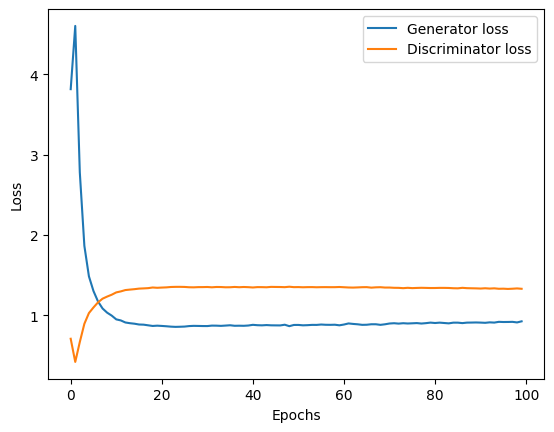

In [10]:
_, ax = plt.subplots()
ax.plot(np.arange(len(losses_g)), losses_g, label='Generator loss')
ax.plot(np.arange(len(losses_d)), losses_d, label='Discriminator loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

#### Generating Fake Data

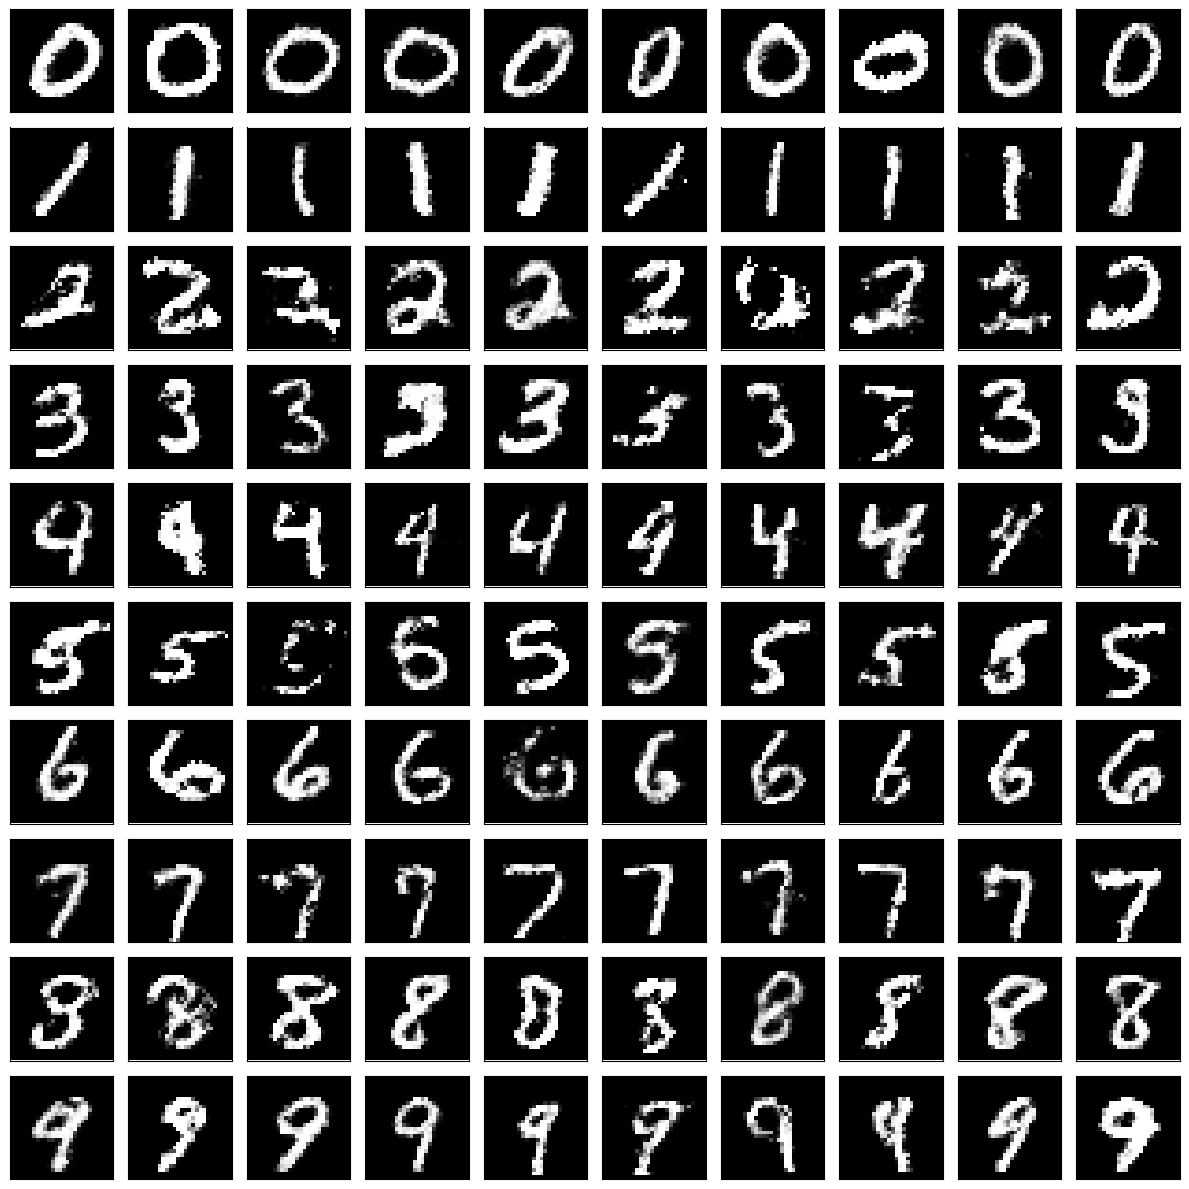

In [13]:
Z = torch.rand(size=(N_ROWS * N_COLS, DIM_NOISE), device=device) * 2 - 1
Y = torch.tensor([i for i in range(0, 10) for _ in range(0, 10)], device=device)
Y = F.one_hot(Y, num_classes=10).float()
data_fake = generator(Z, Y)

_, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
ax = ax.flatten()
for i in range(N_ROWS * N_COLS):
    img = data_fake[i].cpu().detach().numpy().reshape(IMAGE_SHAPE)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_xticks([]),
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()